# Import library


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance

# dataset

In [2]:
df = pd.read_excel('ML for radiation-tolerant materials dataset.xlsx')
df = df.dropna()  # Remove rows with missing values

# Define feature and target columns
target = 'Defects ratio'
exclude_cols = ['Unnamed: 0', target, 'Number of defects', 'Total number of atoms']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target]

# Train/test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Normalize features

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train Random Forest model

In [5]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

# Train Decision Tree model

In [6]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)


DecisionTreeRegressor(random_state=42)

# Train Kernel Ridge Regression model with GridSearchCV

In [7]:
param_grid = {'alpha': np.logspace(-6, 6, 13)}  # Hyperparameter tuning for alpha
krr = KernelRidge(kernel='rbf')  # Using Radial Basis Function (RBF) kernel
grid_search = GridSearchCV(krr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
# Get the best KRR model from GridSearchCV
best_krr = grid_search.best_estimator_

# Train Neural Network model (MLPRegressor) 

In [8]:
nn = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),  # Increased network complexity
    max_iter=5000,  # More iterations to ensure convergence
    activation='relu',  # ReLU activation function for better convergence
    solver='adam',  # Adam optimizer for adaptive learning rate
    alpha=0.0001,  # Regularization to avoid overfitting
    random_state=42,
    learning_rate='adaptive',  # Adaptive learning rate
    early_stopping=True,  # Stop when validation score doesn't improve
    n_iter_no_change=100,  # Early stopping patience
    validation_fraction=0.1,  # Fraction of training data used for validation
    tol=1e-4  # Tolerance for optimization
)
nn.fit(X_train_scaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(512, 256, 128),
             learning_rate='adaptive', max_iter=5000, n_iter_no_change=100,
             random_state=42)

# Predict and evaluate for all models

In [9]:
models = {'Random Forest': rf, 'Decision Tree': dt, 'Kernel Ridge Regression': best_krr, 'Neural Network': nn}
results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    # Calculate NRMSE: Normalized Root Mean Squared Error
    mse = np.mean((y_test - y_pred) ** 2)
    nrmse = np.sqrt(mse) / (y.max() - y.min())
    pearson_corr = pearsonr(y_test, y_pred)[0]
    
    results[model_name] = {
        "NRMSE": nrmse,
        "R² Score": r2,
        "Pearson Correlation": pearson_corr
    }

# Model Evaluation Metrics

In [10]:
print("📊 Model Evaluation Metrics:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


📊 Model Evaluation Metrics:

Random Forest:
NRMSE: 0.0840
R² Score: 0.7214
Pearson Correlation: 0.8820

Decision Tree:
NRMSE: 0.0539
R² Score: 0.8851
Pearson Correlation: 0.9435

Kernel Ridge Regression:
NRMSE: 0.0854
R² Score: 0.7121
Pearson Correlation: 0.8777

Neural Network:
NRMSE: 0.1387
R² Score: 0.2405
Pearson Correlation: 0.5893


#  Plot feature importance for each model

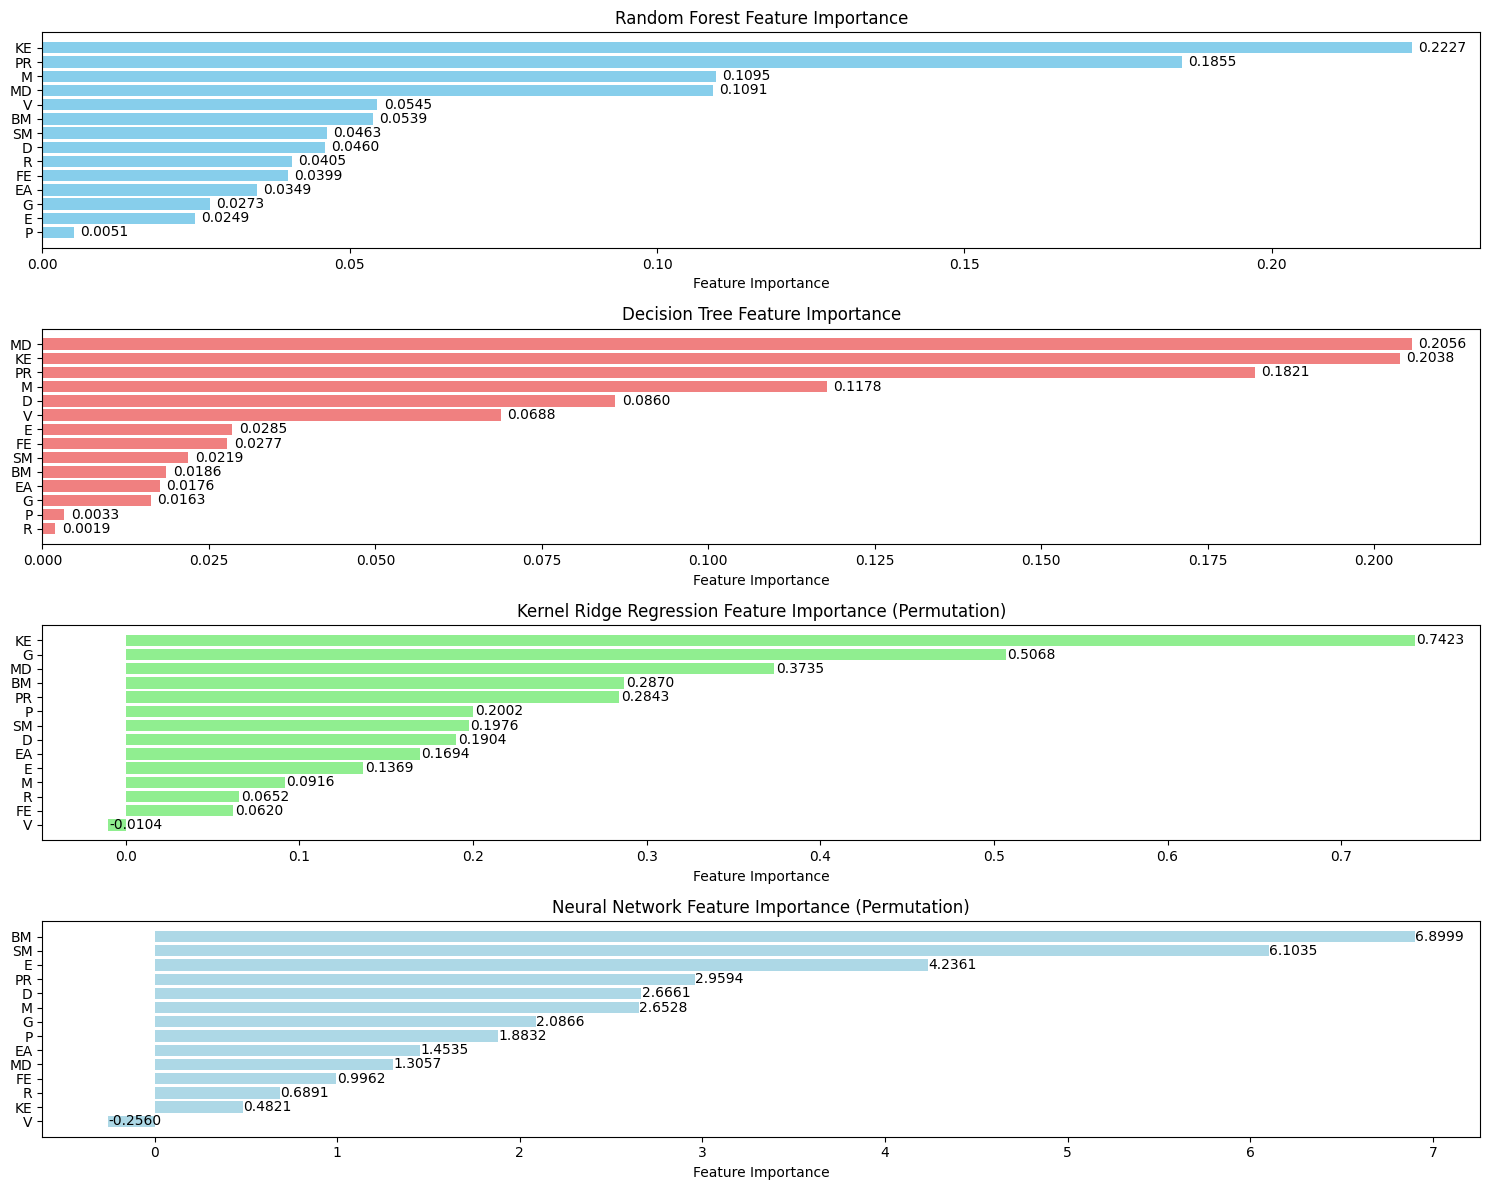

In [16]:
plt.figure(figsize=(15, 12))

# Plot Feature Importance for Random Forest
plt.subplot(4, 1, 1)
importances_rf = rf.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X.columns, 'Importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)
bars_rf = plt.barh(importance_df_rf['Feature'], importance_df_rf['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")

# Annotate each bar for RF
for bar in bars_rf:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f"{width:.4f}", va='center')

# Plot Feature Importance for Decision Tree
plt.subplot(4, 1, 2)
importances_dt = dt.feature_importances_
importance_df_dt = pd.DataFrame({'Feature': X.columns, 'Importance': importances_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)
bars_dt = plt.barh(importance_df_dt['Feature'], importance_df_dt['Importance'], color='lightcoral')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")

# Annotate each bar for DT
for bar in bars_dt:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f"{width:.4f}", va='center')

# Plot Feature Importance for Kernel Ridge Regression (Permutation Importance)
plt.subplot(4, 1, 3)
# Use permutation importance for Kernel Ridge Regression
perm_importance_krr = permutation_importance(best_krr, X_test_scaled, y_test, n_repeats=10, random_state=42)
importance_df_krr = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance_krr.importances_mean})
importance_df_krr = importance_df_krr.sort_values(by='Importance', ascending=False)
bars_krr = plt.barh(importance_df_krr['Feature'], importance_df_krr['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Kernel Ridge Regression Feature Importance (Permutation)")

# Annotate each bar for KRR
for bar in bars_krr:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f"{width:.4f}", va='center')

# Plot Feature Importance for Neural Network
plt.subplot(4, 1, 4)
# Use permutation importance for Neural Network
perm_importance_nn = permutation_importance(nn, X_test_scaled, y_test, n_repeats=10, random_state=42)
importance_df_nn = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance_nn.importances_mean})
importance_df_nn = importance_df_nn.sort_values(by='Importance', ascending=False)
bars_nn = plt.barh(importance_df_nn['Feature'], importance_df_nn['Importance'], color='lightblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Neural Network Feature Importance (Permutation)")

# Annotate each bar for NN
for bar in bars_nn:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f"{width:.4f}", va='center')

plt.tight_layout()
plt.show()